In [1]:
import logging
logging.getLogger('tensorflow').disabled = True
logging.getLogger('adanet').disabled = True

import functools
import os
import shutil
import time
import datetime

import tensorflow as tf
import adanet

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse

In [2]:
(x_train, y_train), (x_test, y_test) = (tf.keras.datasets.boston_housing.load_data())

model_dir = os.path.join(os.getcwd(),'advanced_adanet_dnn_'+str(int(time.time())))

_NUM_LAYERS_KEY = "num_layers"
FEATURES_KEY = "x"
LEARNING_RATE = 0.001
TRAIN_STEPS = 60000
BATCH_SIZE = 32
LEARN_MIXTURE_WEIGHTS = False
ADANET_LAMBDA = .015
ADANET_ITERATIONS = 3
LAYER_SIZE = 64
RANDOM_SEED = 42

In [3]:
def input_fn(partition, training, batch_size):

    def _input_fn():

        if partition == "train":
            dataset = tf.data.Dataset.from_tensor_slices(({
                FEATURES_KEY: tf.log1p(x_train)
            }, tf.log1p(y_train)))
            
            if training:
                dataset = dataset.shuffle(10 * batch_size, seed=RANDOM_SEED).repeat()
                
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_one_shot_iterator()
            features, labels = iterator.get_next()
            return features, labels
            
        elif partition == "test":
            dataset = tf.data.Dataset.from_tensor_slices(({
                FEATURES_KEY: tf.log1p(x_test)
            }, tf.log1p(y_test)))
            
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_one_shot_iterator()
            features, labels = iterator.get_next()
            return features, labels
        
        else:
            dataset = tf.data.Dataset.from_tensor_slices({
                FEATURES_KEY: tf.log1p(x_test)
            })
            dataset = dataset.batch(batch_size)
            iterator = dataset.make_one_shot_iterator()
            features = iterator.get_next()
            return features

    return _input_fn

# likely exposed in a less verbose way within an adanet module, not sure yet.
class _SimpleDNNBuilder(adanet.subnetwork.Builder):
    
    def __init__(self, optimizer, layer_size, num_layers, learn_mixture_weights,
               seed):

        self._optimizer = optimizer
        self._layer_size = LAYER_SIZE
        self._num_layers = num_layers
        self._learn_mixture_weights = learn_mixture_weights
        self._seed = seed

    def build_subnetwork(self,
                       features,
                       logits_dimension,
                       training,
                       iteration_step,
                       summary,
                       previous_ensemble=None):
        

        input_layer = tf.to_float(features[FEATURES_KEY])
        kernel_initializer = tf.glorot_uniform_initializer(seed=self._seed)
        last_layer = input_layer
        for _ in range(self._num_layers):
            last_layer = tf.layers.dense(
                last_layer,
                units=self._layer_size,
                activation=tf.nn.relu,
                kernel_initializer=kernel_initializer)
            
        logits = tf.layers.dense(
            last_layer,
            units=logits_dimension,
            kernel_initializer=kernel_initializer)

        persisted_tensors = {_NUM_LAYERS_KEY: tf.constant(self._num_layers)}
        return adanet.Subnetwork(
            last_layer=last_layer,
            logits=logits,
            complexity=self._measure_complexity(),
            persisted_tensors=persisted_tensors)

    def _measure_complexity(self):
        """Approximates Rademacher complexity as the square-root of the depth."""
        return tf.sqrt(tf.to_float(self._num_layers))

    def build_subnetwork_train_op(self, subnetwork, loss, var_list, labels,
                                  iteration_step, summary, previous_ensemble):

        return self._optimizer.minimize(loss=loss, var_list=var_list)

    def build_mixture_weights_train_op(self, loss, var_list, logits, labels,
                                     iteration_step, summary):

        if not self._learn_mixture_weights:
            return tf.no_op()
        return self._optimizer.minimize(loss=loss, var_list=var_list)

    @property
    def name(self):

        
        if self._num_layers == 0:
            # A DNN with no hidden layers is a linear model.
            return "linear"
        return "{}_layer_dnn".format(self._num_layers)


class SimpleDNNGenerator(adanet.subnetwork.Generator):
    """Generates a two DNN subnetworks at each iteration.

    ------->This is similar to the adaptive network presented in Figure 2 of
    [Cortes et al. ICML 2017](https://arxiv.org/abs/1607.01097), without the
    connections to hidden layers of networks from previous iterations.<-----
    """

    def __init__(self,
               optimizer,
               layer_size=LAYER_SIZE,
               learn_mixture_weights=False,
               seed=None):

        self._seed = seed
        self._dnn_builder_fn = functools.partial(
            _SimpleDNNBuilder,
            optimizer=optimizer,
            layer_size=layer_size,
            learn_mixture_weights=learn_mixture_weights)

    def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):

        
        num_layers = 0
        seed = self._seed
        if previous_ensemble:
            num_layers = tf.contrib.util.constant_value(
                previous_ensemble.weighted_subnetworks[
                    -1].subnetwork.persisted_tensors[_NUM_LAYERS_KEY])
        if seed is not None:
            seed += iteration_number
        return [
            self._dnn_builder_fn(num_layers=num_layers, seed=seed),
            self._dnn_builder_fn(num_layers=num_layers + 1, seed=seed),
        ]


def model_fn(learn_mixture_weights=LEARN_MIXTURE_WEIGHTS,
             adanet_lambda=ADANET_LAMBDA):
    """Trains an `adanet.Estimator` to predict x with regression."""

    estimator = adanet.Estimator(
      head=tf.contrib.estimator.regression_head(
          loss_reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE),

      # Define the generator, which defines our search space of subnetworks
      # to train as candidates to add to the final AdaNet model.
      subnetwork_generator=SimpleDNNGenerator(
          optimizer=tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE),
          learn_mixture_weights=learn_mixture_weights,
          seed=RANDOM_SEED),

      # Lambda is a the strength of complexity regularization. A larger
      # value will penalize more complex subnetworks.
      adanet_lambda=adanet_lambda,

      # The number of train steps per iteration.
      max_iteration_steps=TRAIN_STEPS // ADANET_ITERATIONS,

      # The evaluator will evaluate the model on the full training set to
      # compute the overall AdaNet loss (train loss + complexity
      # regularization) to select the best candidate to include in the
      # final AdaNet model.
      evaluator=adanet.Evaluator(
          input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE)),

      # Configuration for Estimators.
      config=tf.estimator.RunConfig(
          save_summary_steps=5000,
          save_checkpoints_steps=5000,
          tf_random_seed=RANDOM_SEED,
          model_dir=model_dir))


    return estimator

In [4]:
estimator = model_fn(learn_mixture_weights=True,
                     adanet_lambda=ADANET_LAMBDA)

W0705 15:25:07.304993 140248303523648 estimator.py:551] The following arguments have been moved to `adanet.ensemble.ComplexityRegularizedEnsembler` which can be specified in the `ensemblers` argument: ['adanet_lambda']


In [5]:
start_time = time.time()
estimator.train(input_fn=input_fn('train', training=True, batch_size=BATCH_SIZE), steps=TRAIN_STEPS)
print("Training completed in {}.".format(str(datetime.timedelta(seconds=time.time() - start_time))))

W0705 15:25:07.992505 140248303523648 ensemble_builder.py:381] The `build_mixture_weights_train_op` method is deprecated. Please use the `Ensembler#build_train_op` instead.
W0705 15:25:08.174860 140248303523648 ensemble_builder.py:381] The `build_mixture_weights_train_op` method is deprecated. Please use the `Ensembler#build_train_op` instead.
W0705 15:25:49.083365 140248303523648 ensemble_builder.py:381] The `build_mixture_weights_train_op` method is deprecated. Please use the `Ensembler#build_train_op` instead.
W0705 15:25:49.254456 140248303523648 ensemble_builder.py:381] The `build_mixture_weights_train_op` method is deprecated. Please use the `Ensembler#build_train_op` instead.
W0705 15:25:52.438119 140248303523648 ensemble_builder.py:381] The `build_mixture_weights_train_op` method is deprecated. Please use the `Ensembler#build_train_op` instead.
W0705 15:25:52.686848 140248303523648 ensemble_builder.py:381] The `build_mixture_weights_train_op` method is deprecated. Please use th

Training completed in 0:02:35.527531.


In [6]:
metrics = estimator.evaluate(input_fn=input_fn('train', training=False, batch_size=BATCH_SIZE), steps=None)

In [7]:
predictions = estimator.predict(input_fn=input_fn('pred', training=False, batch_size=y_test.shape[0]),
                                yield_single_examples=False)

predictions_list = list(predictions)
predictions_array = predictions_list[0]['predictions']

# convert original data to log scale.
y_test_log = tf.log1p(y_test)
with tf.Session() as sess:
    y_test_log = sess.run(y_test_log)
    
results = pd.DataFrame({'actual':y_test_log, 'hypothesis':np.squeeze(predictions_array)})

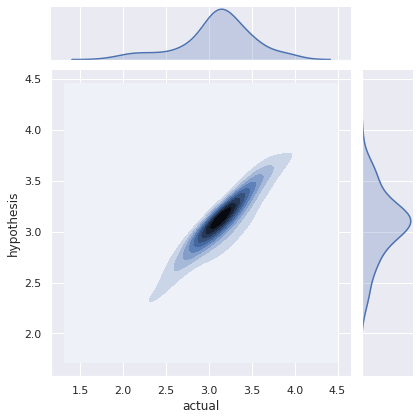

In [8]:
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(16,9)})
sns.jointplot(x="actual", y="hypothesis", data=results, kind="kde");

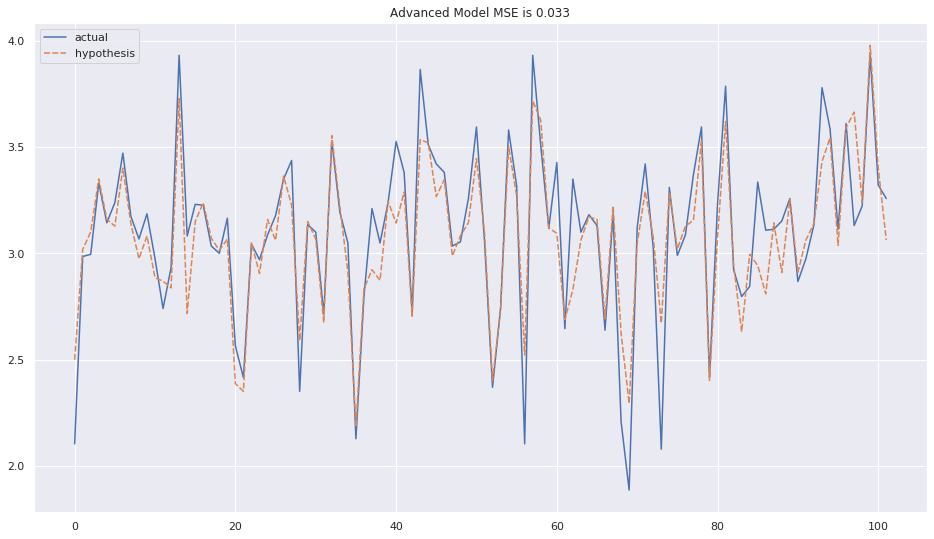

In [9]:
sns.lineplot(data=results).set_title('Advanced Model MSE is {:,}'.format(round(mse(results.actual.values,
                                                                         results.hypothesis.values), 3)));

___